# The Product Pricer Continued

A model that can estimate how much something costs, from its description.

## Baseline Models

Today we work on the simplest models to act as a starting point that we will beat.

In [1]:
# imports

import os
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
from items import Item
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter

In [2]:
# More imports for our traditional machine learning

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

## NLP imports

In the next cell, we have more imports for our NLP related machine learning.  
If the gensim import gives you an error like "Cannot import name 'triu' from 'scipy.linalg' then please run in another cell:  
`!pip install "scipy<1.13"`  
As described on StackOverflow [here](https://stackoverflow.com/questions/78279136/importerror-cannot-import-name-triu-from-scipy-linalg-when-importing-gens).  
Many thanks to students Arnaldo G and Ard V for sorting this.

In [3]:
# NLP related imports

from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

In [4]:
# Finally, more imports for more advanced machine learning

from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor

In [5]:
# Constants - used for printing to stdout in color

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

In [7]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [8]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [9]:
%matplotlib inline

# Loading the pkl files

Let's avoid curating all our data again! Load in the pickle files

If you didn't already create these in Day 2, you can also download them from my google drive (you'll also find the slides here):  
https://drive.google.com/drive/folders/1JwNorpRHdnf_pU0GE5yYtfKlyrKC3CoV?usp=sharing

But note that the files are quite large - you might need to get a coffee!

In [10]:
with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [11]:
# Remind ourselves the training prompt

print(train[0].prompt)

How much does this cost to the nearest dollar?

American Flag Refrigerator Door Handle Covers 2 Pcs Independence?Memorial?Day 4Th of July Kitchen Appliance Handles Patriotic Stars Fridge Protector Gloves Ovens for Stove Dishwasher Microwave
Non-slip Design The reverse side is non-slip fabric, which will fit your kitchen appliance handles and will not slip or fall. Soft as a Cloud High-quality and skin-friendly fabrics. It is soft in your hands with great grip, just like touching the cloud. Tips Due to the lighting effects during photography, there may be slight color differences between pictures and the actual object. Please seal the velcro when machine washing, so it won't stick to other clothes. REFRIGERATOR DOOR HANDLE COVER MATERIAL made of Soft Polyester. It is comfortable and elastic. The refrigerator handle

Price is $12.00


In [12]:
# Remind a test prompt

print(train[0].price)

11.99


## Unveiling a mighty script that we will use a lot!

A rather pleasing Test Harness that will evaluate any model against 250 items from the Test set

And show us the results in a visually satisfying way.

You write a function of this form:

```
def my_prediction_function(item):
    # my code here
    return my_estimate
```

And then you call:

`Tester.test(my_prediction_function)`

To evaluate your model.

In [13]:
class Tester:

    def __init__(self, predictor, title=None, data=test, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"
    
    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint)
        truth = datapoint.price
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint.title if len(datapoint.title) <= 40 else datapoint.title[:40]+"..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function):
        cls(function).run()

# Now for something basic

What's the very simplest model you could imagine?

Let's start with a random number generator!

In [14]:
def random_pricer(item):
    return random.randrange(1,1000)

1: Guess: $655.00 Truth: $13.99 Error: $641.01 SLE: 14.28 Item: GOLDTONE Brand Replacement Charcoal Wate...
2: Guess: $115.00 Truth: $9.98 Error: $105.02 SLE: 5.56 Item: Flngr 240530701 Pan Hanger (Right) for R...
3: Guess: $26.00 Truth: $944.26 Error: $918.26 SLE: 12.64 Item: Kenmore 20362 3.8 cu. ft. Top-Load Washe...
4: Guess: $760.00 Truth: $56.21 Error: $703.79 SLE: 6.70 Item: XiKe W10285625 Front Load Washer Tub Bea...
5: Guess: $282.00 Truth: $10.99 Error: $271.01 SLE: 9.99 Item: Lifetime Warranty W10837240 Dryer Idler ...
6: Guess: $251.00 Truth: $9.50 Error: $241.50 SLE: 10.10 Item: LaMi Products Economy Kitchen Accessory ...
7: Guess: $229.00 Truth: $18.74 Error: $210.26 SLE: 6.03 Item: Whirlpool W10258275 Bimetal Fuse for Dis...
8: Guess: $143.00 Truth: $32.54 Error: $110.46 SLE: 2.12 Item: Frigidaire 297259528 Start Device, White
9: Guess: $755.00 Truth: $27.76 Error: $727.24 SLE: 10.69 Item: Builder's Best CECOMINOD018526 J-Block D...
10: Guess: $105.00 Truth: $304.98 Erro

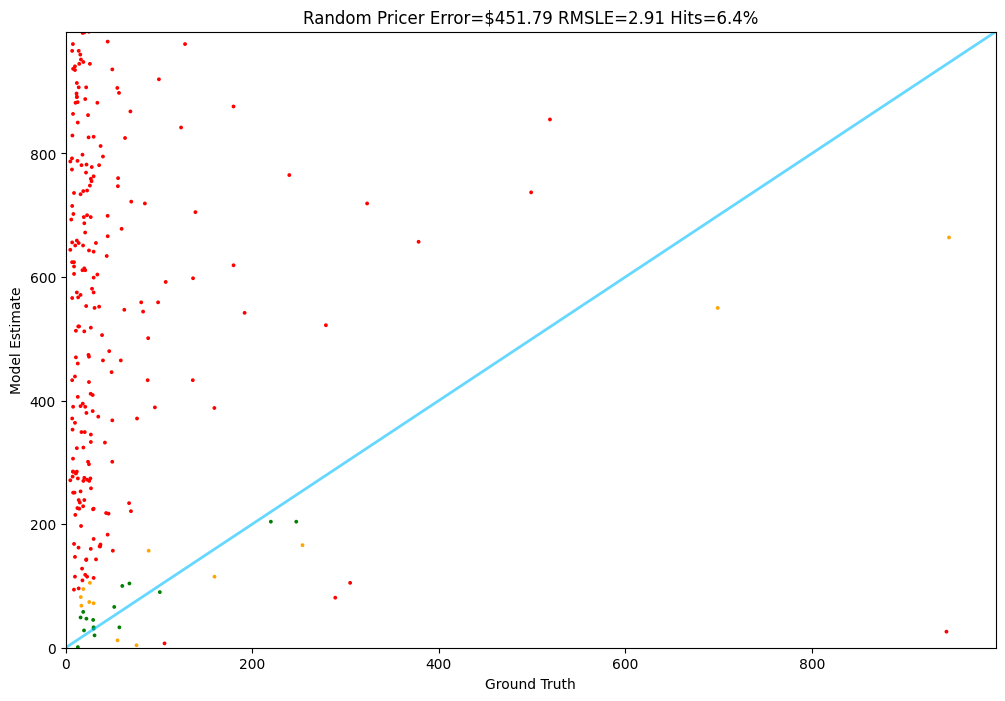

In [15]:
# Set the random seed

random.seed(42)

# Run our TestRunner
Tester.test(random_pricer)

In [16]:
# That was fun!
# We can do better - here's another rather trivial model

training_prices = [item.price for item in train]
training_average = sum(training_prices) / len(training_prices)

def constant_pricer(item):
    return training_average

1: Guess: $58.30 Truth: $13.99 Error: $44.31 SLE: 1.89 Item: GOLDTONE Brand Replacement Charcoal Wate...
2: Guess: $58.30 Truth: $9.98 Error: $48.32 SLE: 2.84 Item: Flngr 240530701 Pan Hanger (Right) for R...
3: Guess: $58.30 Truth: $944.26 Error: $885.96 SLE: 7.67 Item: Kenmore 20362 3.8 cu. ft. Top-Load Washe...
4: Guess: $58.30 Truth: $56.21 Error: $2.09 SLE: 0.00 Item: XiKe W10285625 Front Load Washer Tub Bea...
5: Guess: $58.30 Truth: $10.99 Error: $47.31 SLE: 2.56 Item: Lifetime Warranty W10837240 Dryer Idler ...
6: Guess: $58.30 Truth: $9.50 Error: $48.80 SLE: 3.00 Item: LaMi Products Economy Kitchen Accessory ...
7: Guess: $58.30 Truth: $18.74 Error: $39.56 SLE: 1.21 Item: Whirlpool W10258275 Bimetal Fuse for Dis...
8: Guess: $58.30 Truth: $32.54 Error: $25.76 SLE: 0.32 Item: Frigidaire 297259528 Start Device, White
9: Guess: $58.30 Truth: $27.76 Error: $30.54 SLE: 0.52 Item: Builder's Best CECOMINOD018526 J-Block D...
10: Guess: $58.30 Truth: $304.98 Error: $246.68 SLE: 2.69 I

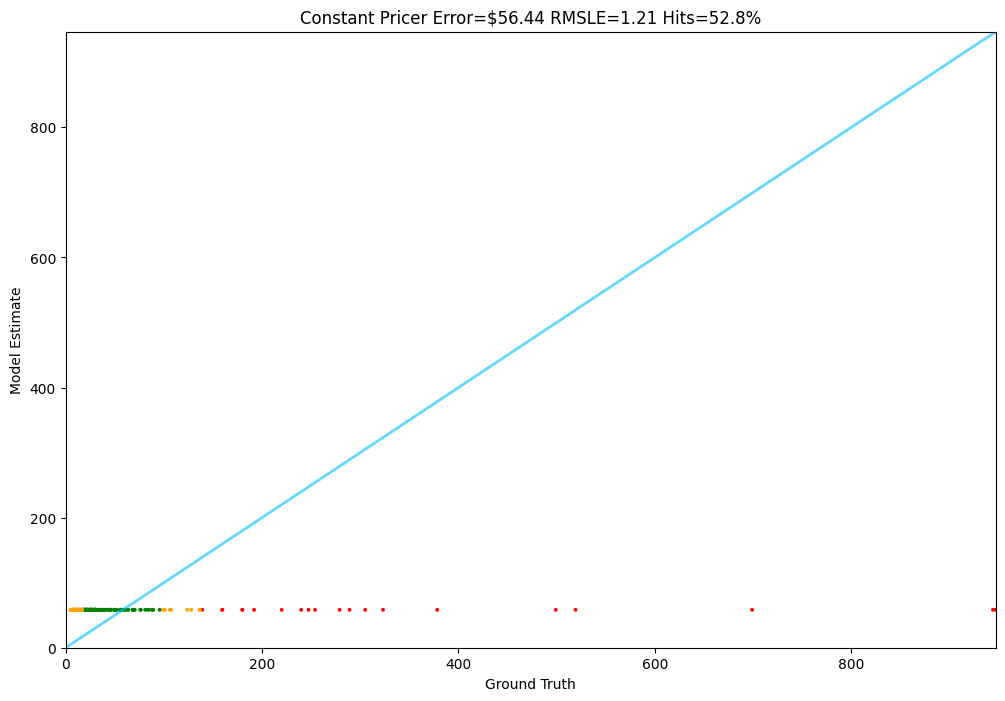

In [17]:
# Run our constant predictor
Tester.test(constant_pricer)


In [18]:
train[0].details

'{"Material": "Polyester", "Brand": "Boccsty", "Color": "American Star", "Style": "Funny,Patriotic", "Product Dimensions": "14\\"L x 5.5\\"W", "Number of Pieces": "2", "Shape": "Rectangular", "Special Feature": "Easy to Install, Durable", "Unit Count": "2.0 Count", "Brand Name": "Boccsty", "Item Weight": "3.52 ounces", "Noise": "0.03 dB", "Special Features": "Easy to Install, Durable", "Voltage": "1 Volts", "Material Type": "Polyester", "Batteries Included?": "No", "Batteries Required?": "No", "Best Sellers Rank": {"Tools & Home Improvement": 145958, "Refrigerator Replacement Handles": 110}, "Date First Available": "December 27, 2021"}'

In [19]:
# Create a new "features" field on items, and populate it with json parsed from the details dict

for item in train:
    item.features = json.loads(item.details)
for item in test:
    item.features = json.loads(item.details)

# Look at one

In [20]:
train[0].features.keys()

dict_keys(['Material', 'Brand', 'Color', 'Style', 'Product Dimensions', 'Number of Pieces', 'Shape', 'Special Feature', 'Unit Count', 'Brand Name', 'Item Weight', 'Noise', 'Special Features', 'Voltage', 'Material Type', 'Batteries Included?', 'Batteries Required?', 'Best Sellers Rank', 'Date First Available'])

In [21]:
# Look at 20 most common features in training set

feature_count = Counter()
for item in train:
    for f in item.features.keys():
        feature_count[f]+=1

feature_count.most_common(40)

[('Date First Available', 24246),
 ('Best Sellers Rank', 22851),
 ('Item Weight', 20671),
 ('Item model number', 18168),
 ('Manufacturer', 17626),
 ('Part Number', 17206),
 ('Batteries Required?', 15375),
 ('Brand', 14461),
 ('Product Dimensions', 14286),
 ('Batteries Included?', 12659),
 ('Is Discontinued By Manufacturer', 9671),
 ('Color', 9344),
 ('Material', 9278),
 ('Package Dimensions', 8020),
 ('Brand Name', 6362),
 ('Included Components', 6202),
 ('Item Package Quantity', 5774),
 ('Country of Origin', 5264),
 ('Model Info', 4793),
 ('Special Features', 3396),
 ('Shape', 3274),
 ('Number of Pieces', 3251),
 ('Special Feature', 3242),
 ('Material Type', 2857),
 ('Style', 2791),
 ('Size', 2564),
 ('Voltage', 2562),
 ('Item Dimensions LxWxH', 2440),
 ('Unit Count', 2187),
 ('External Testing Certification', 2025),
 ('Compatible Devices', 1955),
 ('Finish Type', 1933),
 ('Warranty Description', 1875),
 ('Capacity', 1773),
 ('Number of Items', 1467),
 ('Power Source', 1423),
 ('Domes

In [22]:
# Now some janky code to pluck out the Item Weight
# Don't worry too much about this: spoiler alert, it's not going to be much use in training!

def get_weight(item):
    weight_str = item.features.get('Item Weight')
    if weight_str:
        parts = weight_str.split(' ')
        amount = float(parts[0])
        unit = parts[1].lower()
        if unit=="pounds":
            return amount
        elif unit=="ounces":
            return amount / 16
        elif unit=="grams":
            return amount / 453.592
        elif unit=="milligrams":
            return amount / 453592
        elif unit=="kilograms":
            return amount / 0.453592
        elif unit=="hundredths" and parts[2].lower()=="pounds":
            return amount / 100
        else:
            print(weight_str)
    return None

In [23]:
weights = [get_weight(t) for t in train]
weights = [w for w in weights if w]

In [24]:
average_weight = sum(weights)/len(weights)
average_weight

3.895165122860338

In [25]:
def get_weight_with_default(item):
    weight = get_weight(item)
    return weight or average_weight

In [26]:
def get_rank(item):
    rank_dict = item.features.get("Best Sellers Rank")
    if rank_dict:
        ranks = rank_dict.values()
        return sum(ranks)/len(ranks)
    return None

In [27]:
ranks = [get_rank(t) for t in train]
ranks = [r for r in ranks if r]
average_rank = sum(ranks)/len(ranks)
average_rank

237890.55146983697

In [28]:
def get_rank_with_default(item):
    rank = get_rank(item)
    return rank or average_rank

In [29]:
def get_text_length(item):
    return len(item.test_prompt())

In [30]:
# investigate the brands

brands = Counter()
for t in train:
    brand = t.features.get("Brand")
    if brand:
        brands[brand]+=1

# Look at most common 40 brands

brands.most_common(40)

[('GE', 493),
 ('Upstart Battery', 492),
 ('Whirlpool', 482),
 ('Frigidaire', 425),
 ('Supplying Demand', 293),
 ('UpStart Components', 201),
 ('SAMSUNG', 194),
 ('BlueStars', 155),
 ('ICEPURE', 140),
 ('Supco', 139),
 ('LG', 122),
 ('Lifetime Appliance Parts', 99),
 ('AMI PARTS', 94),
 ('PartsBroz', 94),
 ('Broan-NuTone', 93),
 ('Swift Green Filters', 83),
 ('Waterdrop', 75),
 ('Beaquicy', 74),
 ('Air Filter Factory', 71),
 ('Electrolux', 69),
 ('Nostalgic Warehouse', 67),
 ('Generic', 65),
 ('Wowfeel', 60),
 ('Empava', 60),
 ('Aqua Fresh', 57),
 ('Melitta', 55),
 ('PUREPLUS', 55),
 ('HQRP', 54),
 ('Seentech', 51),
 ('AQUA CREST', 50),
 ('BUNN', 49),
 ('EXCELPURE', 48),
 ('Tier1', 48),
 ('Edgewater Parts', 47),
 ('Denali Pure', 47),
 ('COSTWAY', 47),
 ('Refresh', 46),
 ('Nispira', 45),
 ('BRBHOM', 45),
 ('Range Kleen', 43)]

In [31]:
TOP_ELECTRONICS_BRANDS = ["hp", "dell", "lenovo", "samsung", "asus", "sony", "canon", "apple", "intel"]
def is_top_electronics_brand(item):
    brand = item.features.get("Brand")
    return brand and brand.lower() in TOP_ELECTRONICS_BRANDS

In [32]:
def get_features(item):
    return {
        "weight": get_weight_with_default(item),
        "rank": get_rank_with_default(item),
        "text_length": get_text_length(item),
        "is_top_electronics_brand": 1 if is_top_electronics_brand(item) else 0
    }

In [33]:
# Look at features in a training item
get_features(train[0])

{'weight': 0.22,
 'rank': 73034.0,
 'text_length': 837,
 'is_top_electronics_brand': 0}

In [34]:
# A utility function to convert our features into a pandas dataframe

def list_to_dataframe(items):
    features = [get_features(item) for item in items]
    df = pd.DataFrame(features)
    df['price'] = [item.price for item in items]
    return df

train_df = list_to_dataframe(train)
test_df = list_to_dataframe(test[:250])

In [54]:
train_df.head()

,weight,rank,text_length,is_top_electronics_brand,price
0,0.220000,73034.0,837,0,11.99
1,1.550000,45070.5,785,0,30.96
2,0.568750,387865.0,787,0,102.14
3,0.110000,99686.0,721,0,10.98
4,3.895165,462031.0,740,0,11.97


In [55]:
test_df.head()

,weight,rank,text_length,is_top_electronics_brand,price
0,0.700000,405487.0,711,0,13.99
1,0.180625,102361.0,731,0,9.98
2,115.000000,3102.0,802,0,944.26
3,1.060000,483030.0,676,0,56.21
4,0.400000,13215.0,433,0,10.99


In [35]:
# Traditional Linear Regression!

np.random.seed(42)

# Separate features and target
feature_columns = ['weight', 'rank', 'text_length', 'is_top_electronics_brand']

X_train = train_df[feature_columns]
y_train = train_df['price']
X_test = test_df[feature_columns]
y_test = test_df['price']

# Train a Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

for feature, coef in zip(feature_columns, model.coef_):
    print(f"{feature}: {coef}")
print(f"Intercept: {model.intercept_}")

# Predict the test set and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

weight: 5.019301999511715
rank: -1.2393172442813014e-05
text_length: 0.032757664980100534
is_top_electronics_brand: 7.025413914608958
Intercept: 15.98126461973925
Mean Squared Error: 4504.440125603757
R-squared Score: 0.6554582419400177


In [36]:
# Function to predict price for a new item

def linear_regression_pricer(item):
    features = get_features(item)
    features_df = pd.DataFrame([features])
    return model.predict(features_df)[0]

1: Guess: $37.76 Truth: $13.99 Error: $23.77 SLE: 0.90 Item: GOLDTONE Brand Replacement Charcoal Wate...
2: Guess: $39.57 Truth: $9.98 Error: $29.59 SLE: 1.71 Item: Flngr 240530701 Pan Hanger (Right) for R...
3: Guess: $619.43 Truth: $944.26 Error: $324.83 SLE: 0.18 Item: Kenmore 20362 3.8 cu. ft. Top-Load Washe...
4: Guess: $37.46 Truth: $56.21 Error: $18.75 SLE: 0.16 Item: XiKe W10285625 Front Load Washer Tub Bea...
5: Guess: $32.01 Truth: $10.99 Error: $21.02 SLE: 1.03 Item: Lifetime Warranty W10837240 Dryer Idler ...
6: Guess: $41.07 Truth: $9.50 Error: $31.57 SLE: 1.93 Item: LaMi Products Economy Kitchen Accessory ...
7: Guess: $42.90 Truth: $18.74 Error: $24.16 SLE: 0.64 Item: Whirlpool W10258275 Bimetal Fuse for Dis...
8: Guess: $43.02 Truth: $32.54 Error: $10.48 SLE: 0.07 Item: Frigidaire 297259528 Start Device, White
9: Guess: $38.79 Truth: $27.76 Error: $11.03 SLE: 0.11 Item: Builder's Best CECOMINOD018526 J-Block D...
10: Guess: $57.22 Truth: $304.98 Error: $247.76 SLE: 2.75

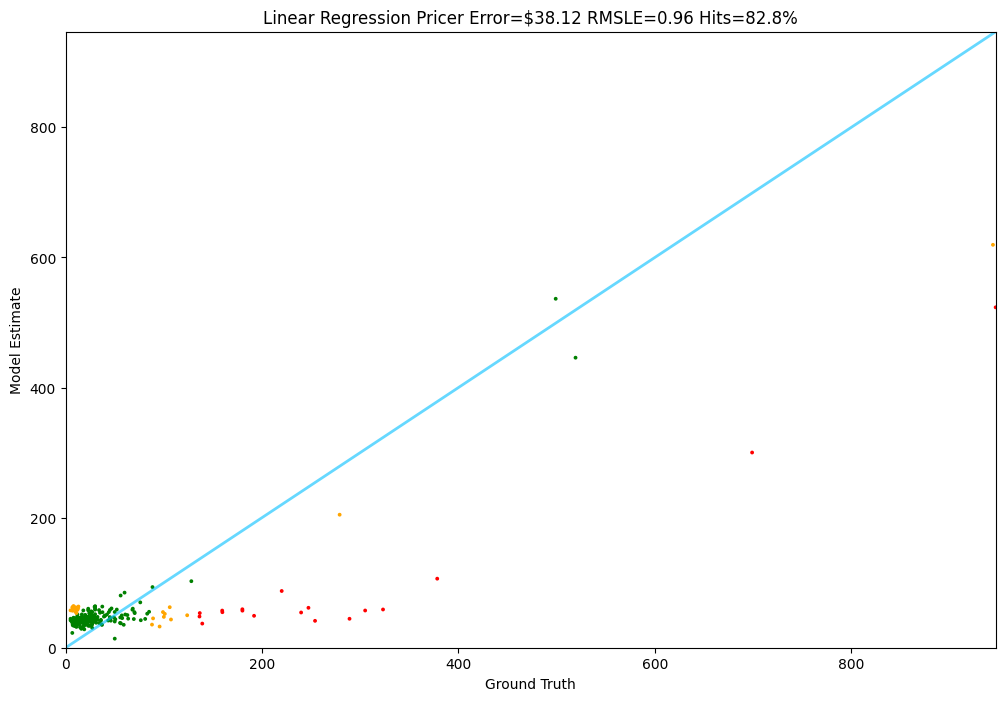

In [37]:
# test it

Tester.test(linear_regression_pricer)

In [38]:
# For the next few models, we prepare our documents and prices
# Note that we use the test prompt for the documents, otherwise we'll reveal the answer!!

prices = np.array([float(item.price) for item in train])
documents = [item.test_prompt() for item in train]

In [56]:
documents[0]

"How much does this cost to the nearest dollar?\n\nAmerican Flag Refrigerator Door Handle Covers 2 Pcs Independence?Memorial?Day 4Th of July Kitchen Appliance Handles Patriotic Stars Fridge Protector Gloves Ovens for Stove Dishwasher Microwave\nNon-slip Design The reverse side is non-slip fabric, which will fit your kitchen appliance handles and will not slip or fall. Soft as a Cloud High-quality and skin-friendly fabrics. It is soft in your hands with great grip, just like touching the cloud. Tips Due to the lighting effects during photography, there may be slight color differences between pictures and the actual object. Please seal the velcro when machine washing, so it won't stick to other clothes. REFRIGERATOR DOOR HANDLE COVER MATERIAL made of Soft Polyester. It is comfortable and elastic. The refrigerator handle\n\nPrice is $"

In [39]:
# Use the CountVectorizer for a Bag of Words model

np.random.seed(42)
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(documents)
regressor = LinearRegression()
regressor.fit(X, prices)

LinearRegression()

In [40]:
def bow_lr_pricer(item):
    x = vectorizer.transform([item.test_prompt()])
    return max(regressor.predict(x)[0], 0)

1: Guess: $57.66 Truth: $13.99 Error: $43.67 SLE: 1.86 Item: GOLDTONE Brand Replacement Charcoal Wate...
2: Guess: $37.24 Truth: $9.98 Error: $27.26 SLE: 1.56 Item: Flngr 240530701 Pan Hanger (Right) for R...
3: Guess: $237.06 Truth: $944.26 Error: $707.20 SLE: 1.90 Item: Kenmore 20362 3.8 cu. ft. Top-Load Washe...
4: Guess: $57.02 Truth: $56.21 Error: $0.81 SLE: 0.00 Item: XiKe W10285625 Front Load Washer Tub Bea...
5: Guess: $46.25 Truth: $10.99 Error: $35.26 SLE: 1.88 Item: Lifetime Warranty W10837240 Dryer Idler ...
6: Guess: $46.11 Truth: $9.50 Error: $36.61 SLE: 2.25 Item: LaMi Products Economy Kitchen Accessory ...
7: Guess: $48.82 Truth: $18.74 Error: $30.08 SLE: 0.86 Item: Whirlpool W10258275 Bimetal Fuse for Dis...
8: Guess: $91.31 Truth: $32.54 Error: $58.77 SLE: 1.02 Item: Frigidaire 297259528 Start Device, White
9: Guess: $87.47 Truth: $27.76 Error: $59.71 SLE: 1.26 Item: Builder's Best CECOMINOD018526 J-Block D...
10: Guess: $275.58 Truth: $304.98 Error: $29.40 SLE: 0.01 

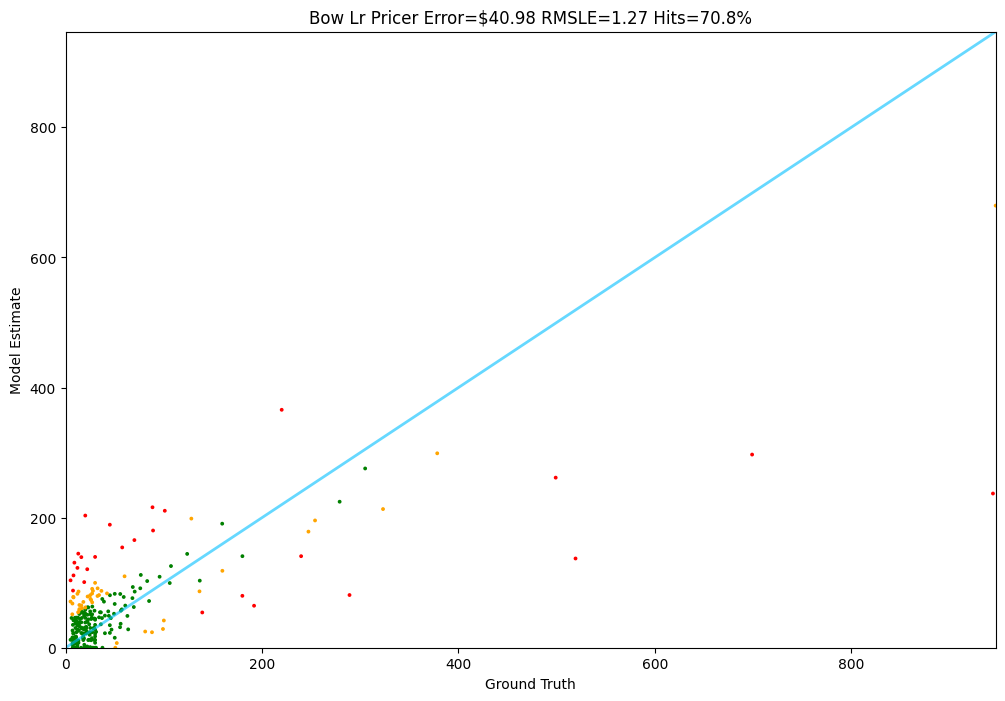

In [41]:
# test it

Tester.test(bow_lr_pricer)

In [42]:
# The amazing word2vec model, implemented in gensim NLP library

np.random.seed(42)

# Preprocess the documents
processed_docs = [simple_preprocess(doc) for doc in documents]

# Train Word2Vec model
w2v_model = Word2Vec(sentences=processed_docs, vector_size=400, window=5, min_count=1, workers=8)

In [43]:
# This step of averaging vectors across the document is a weakness in our approach

def document_vector(doc):
    doc_words = simple_preprocess(doc)
    word_vectors = [w2v_model.wv[word] for word in doc_words if word in w2v_model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(w2v_model.vector_size)

# Create feature matrix
X_w2v = np.array([document_vector(doc) for doc in documents])

In [44]:
# Run Linear Regression on word2vec

word2vec_lr_regressor = LinearRegression()
word2vec_lr_regressor.fit(X_w2v, prices)

LinearRegression()

In [45]:
def word2vec_lr_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, word2vec_lr_regressor.predict([doc_vector])[0])

1: Guess: $34.39 Truth: $13.99 Error: $20.40 SLE: 0.74 Item: GOLDTONE Brand Replacement Charcoal Wate...
2: Guess: $79.37 Truth: $9.98 Error: $69.39 SLE: 3.96 Item: Flngr 240530701 Pan Hanger (Right) for R...
3: Guess: $249.67 Truth: $944.26 Error: $694.59 SLE: 1.76 Item: Kenmore 20362 3.8 cu. ft. Top-Load Washe...
4: Guess: $112.25 Truth: $56.21 Error: $56.04 SLE: 0.47 Item: XiKe W10285625 Front Load Washer Tub Bea...
5: Guess: $0.00 Truth: $10.99 Error: $10.99 SLE: 6.17 Item: Lifetime Warranty W10837240 Dryer Idler ...
6: Guess: $71.62 Truth: $9.50 Error: $62.12 SLE: 3.74 Item: LaMi Products Economy Kitchen Accessory ...
7: Guess: $44.98 Truth: $18.74 Error: $26.24 SLE: 0.71 Item: Whirlpool W10258275 Bimetal Fuse for Dis...
8: Guess: $69.70 Truth: $32.54 Error: $37.16 SLE: 0.56 Item: Frigidaire 297259528 Start Device, White
9: Guess: $101.62 Truth: $27.76 Error: $73.86 SLE: 1.62 Item: Builder's Best CECOMINOD018526 J-Block D...
10: Guess: $226.16 Truth: $304.98 Error: $78.82 SLE: 0.0

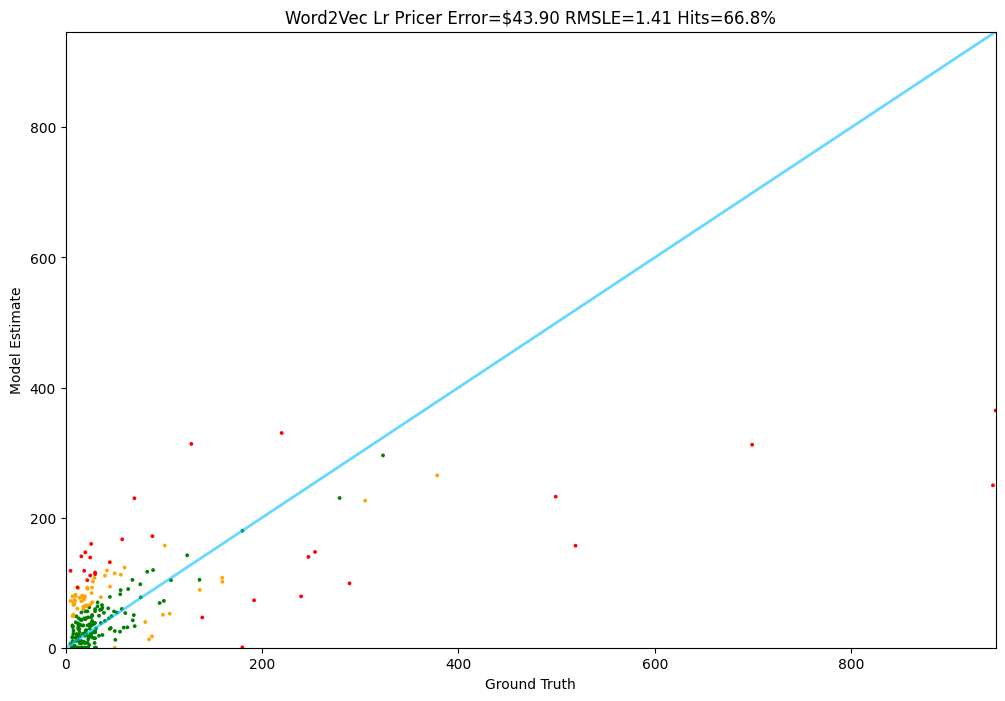

In [46]:
Tester.test(word2vec_lr_pricer)

In [47]:
# Support Vector Machines

np.random.seed(42)
svr_regressor = LinearSVR()

svr_regressor.fit(X_w2v, prices)

LinearSVR()

In [48]:
def svr_pricer(item):
    np.random.seed(42)
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(float(svr_regressor.predict([doc_vector])[0]),0)

1: Guess: $11.34 Truth: $13.99 Error: $2.65 SLE: 0.04 Item: GOLDTONE Brand Replacement Charcoal Wate...
2: Guess: $27.13 Truth: $9.98 Error: $17.15 SLE: 0.89 Item: Flngr 240530701 Pan Hanger (Right) for R...
3: Guess: $78.81 Truth: $944.26 Error: $865.45 SLE: 6.11 Item: Kenmore 20362 3.8 cu. ft. Top-Load Washe...
4: Guess: $46.76 Truth: $56.21 Error: $9.45 SLE: 0.03 Item: XiKe W10285625 Front Load Washer Tub Bea...
5: Guess: $0.00 Truth: $10.99 Error: $10.99 SLE: 6.17 Item: Lifetime Warranty W10837240 Dryer Idler ...
6: Guess: $32.43 Truth: $9.50 Error: $22.93 SLE: 1.34 Item: LaMi Products Economy Kitchen Accessory ...
7: Guess: $29.99 Truth: $18.74 Error: $11.25 SLE: 0.20 Item: Whirlpool W10258275 Bimetal Fuse for Dis...
8: Guess: $37.31 Truth: $32.54 Error: $4.77 SLE: 0.02 Item: Frigidaire 297259528 Start Device, White
9: Guess: $39.84 Truth: $27.76 Error: $12.08 SLE: 0.12 Item: Builder's Best CECOMINOD018526 J-Block D...
10: Guess: $101.32 Truth: $304.98 Error: $203.66 SLE: 1.20 Ite

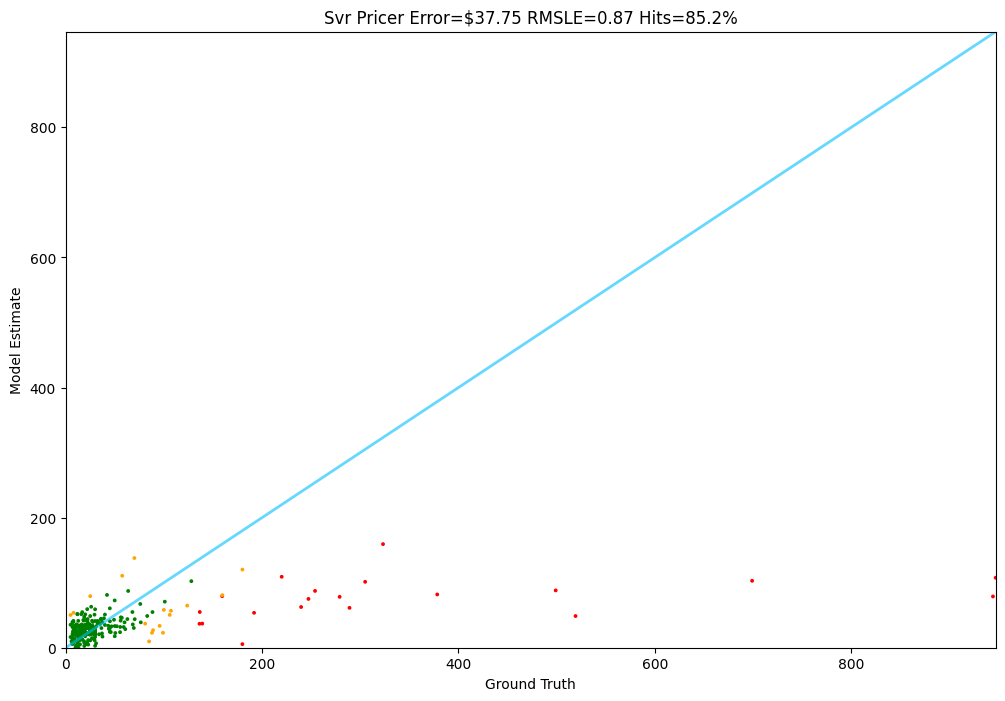

In [49]:
Tester.test(svr_pricer)

In [50]:
# And the powerful Random Forest regression

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=8)
rf_model.fit(X_w2v, prices)

RandomForestRegressor(n_jobs=8, random_state=42)

In [51]:
X_w2v[0]

array([-0.20089309,  0.11149827, -0.01280127, -0.2248148 , -0.16787733,
        0.3600545 ,  0.12577976, -0.01458364, -0.2315636 ,  0.09179749,
       -0.2114755 , -0.10320263, -0.03307428,  0.30772433, -0.01579036,
       -0.24994956,  0.1762846 ,  0.10652364, -0.33530557, -0.11291243,
        0.43599135, -0.25503284,  0.30819863, -0.28576148,  0.29000923,
        0.33110988,  0.12918057,  0.11927533,  0.20597462, -0.20578808,
        0.02401134,  0.14353514, -0.14417271, -0.1562381 , -0.08982796,
       -0.05530629, -0.19723977,  0.2682034 ,  0.153292  , -0.05415882,
       -0.01019827, -0.33031067, -0.24729156, -0.11734405, -0.17361327,
        0.38480163, -0.07407533,  0.02418479, -0.25525063,  0.04700479,
       -0.12709193, -0.08541486, -0.29441974, -0.14277886,  0.28644928,
        0.06452727,  0.04984236, -0.14557077, -0.16042762, -0.1655587 ,
       -0.1234583 , -0.0528288 , -0.27671283, -0.27908763, -0.11058418,
       -0.01622338,  0.00820593, -0.06412042,  0.08039067,  0.19

In [52]:
def random_forest_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, rf_model.predict([doc_vector])[0])

1: Guess: $14.38 Truth: $13.99 Error: $0.39 SLE: 0.00 Item: GOLDTONE Brand Replacement Charcoal Wate...
2: Guess: $28.88 Truth: $9.98 Error: $18.90 SLE: 1.00 Item: Flngr 240530701 Pan Hanger (Right) for R...
3: Guess: $355.92 Truth: $944.26 Error: $588.34 SLE: 0.95 Item: Kenmore 20362 3.8 cu. ft. Top-Load Washe...
4: Guess: $32.68 Truth: $56.21 Error: $23.53 SLE: 0.28 Item: XiKe W10285625 Front Load Washer Tub Bea...
5: Guess: $19.15 Truth: $10.99 Error: $8.16 SLE: 0.27 Item: Lifetime Warranty W10837240 Dryer Idler ...
6: Guess: $50.44 Truth: $9.50 Error: $40.94 SLE: 2.53 Item: LaMi Products Economy Kitchen Accessory ...
7: Guess: $26.81 Truth: $18.74 Error: $8.07 SLE: 0.12 Item: Whirlpool W10258275 Bimetal Fuse for Dis...
8: Guess: $75.05 Truth: $32.54 Error: $42.51 SLE: 0.67 Item: Frigidaire 297259528 Start Device, White
9: Guess: $36.58 Truth: $27.76 Error: $8.82 SLE: 0.07 Item: Builder's Best CECOMINOD018526 J-Block D...
10: Guess: $169.96 Truth: $304.98 Error: $135.02 SLE: 0.34 It

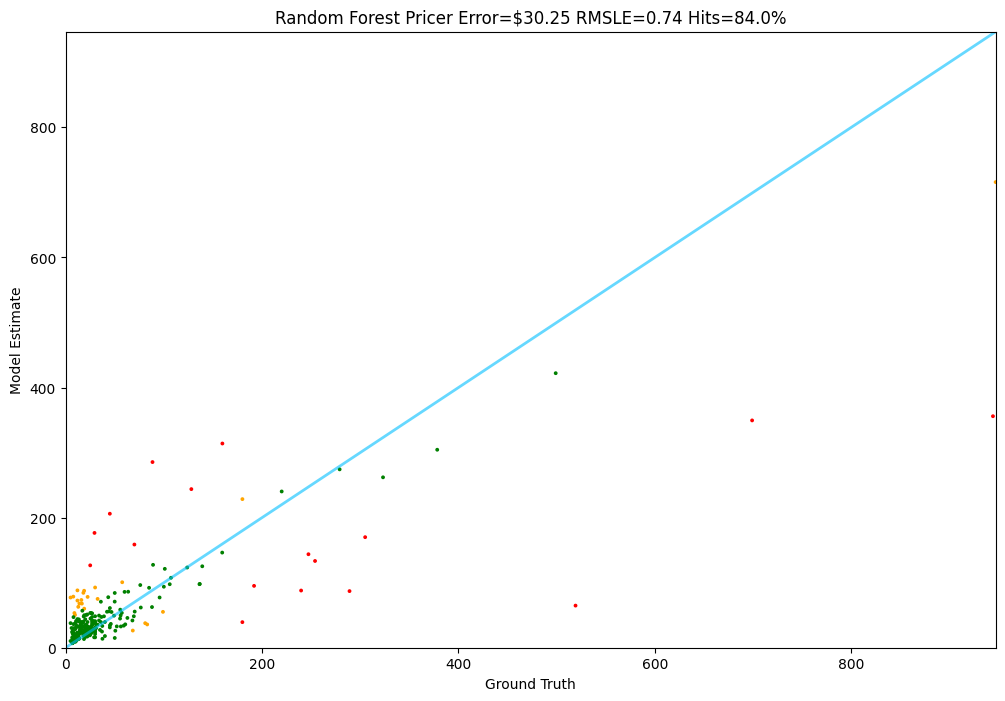

In [53]:
Tester.test(random_forest_pricer)